# From `zipline` to `pyfolio`

[Pyfolio](http://quantopian.github.io/pyfolio/) facilitates the analysis of portfolio performance and risk in-sample and out-of-sample using many standard metrics. It produces tear sheets covering the analysis of returns, positions, and transactions, as well as event risk during periods of market stress using several built-in scenarios, and also includes Bayesian out-of-sample performance analysis.

* Open-source backtester by Quantopian Inc.
* Powers Quantopian.com
* State-of-the-art portfolio and risk analytics
* Various models for transaction costs and slippage.
* Open source and free: Apache v2 license
* Can be used:
   - stand alone
   - with Zipline
   - on Quantopian

Run this note the following from the command line to create a `conda` environment with `zipline` and `pyfolio`: 
```
conda env create -f environment.yml
```
This assumes you have miniconda3 installed.

## Imports & Settings

In [1]:
from pathlib import Path
import warnings
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from pyfolio.plotting import (plot_perf_stats,
                              show_perf_stats,
                              plot_rolling_beta,
                              plot_rolling_fama_french,
                              plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_rolling_volatility,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)

from pyfolio.timeseries import perf_stats, extract_interesting_date_ranges
# from pyfolio.tears import create_returns_tear_sheet

In [3]:
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## Converting data from zipline to pyfolio

In [4]:
with pd.HDFStore('../01_trading_zipline/backtests.h5') as store:
    backtest = store['backtest']
backtest.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2013 entries, 2010-01-04 to 2017-12-29
Data columns (total 39 columns):
algo_volatility            2012 non-null float64
algorithm_period_return    2013 non-null float64
alpha                      2012 non-null float64
benchmark_period_return    2013 non-null float64
benchmark_volatility       2012 non-null float64
beta                       2012 non-null float64
capital_used               2013 non-null float64
ending_cash                2013 non-null float64
ending_exposure            2013 non-null float64
ending_value               2013 non-null float64
excess_return              2013 non-null float64
factor_data                2013 non-null object
gross_leverage             2013 non-null float64
long_exposure              2013 non-null float64
long_value                 2013 non-null float64
longs_count                2013 non-null int64
max_drawdown               2013 non-null float64
max_leverage               2013 non-null floa

`pyfolio` relies on portfolio returns and position data, and can also take into account the transaction costs and slippage losses of trading activity. The metrics are computed using the empyrical library that can also be used on a standalone basis. The performance DataFrame produced by the zipline backtesting engine can be translated into the requisite pyfolio input.

In [5]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(backtest)

In [6]:
returns.head().append(returns.tail())

2010-01-04 00:00:00+00:00    0.000000
2010-01-05 00:00:00+00:00   -0.000013
2010-01-06 00:00:00+00:00    0.003291
2010-01-07 00:00:00+00:00   -0.001066
2010-01-08 00:00:00+00:00    0.002430
2017-12-22 00:00:00+00:00   -0.006448
2017-12-26 00:00:00+00:00   -0.001845
2017-12-27 00:00:00+00:00    0.001239
2017-12-28 00:00:00+00:00    0.004486
2017-12-29 00:00:00+00:00   -0.005241
Name: returns, dtype: float64

In [9]:
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2012 entries, 2010-01-05 to 2017-12-29
Columns: 1717 entries, A to cash
dtypes: float64(1717)
memory usage: 26.4 MB


In [10]:
positions.columns = [c for c in positions.columns[:-1]] + ['cash']
positions.index = positions.index.normalize()
positions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2012 entries, 2010-01-05 to 2017-12-29
Columns: 1717 entries, A to cash
dtypes: float64(1717)
memory usage: 26.4 MB


In [11]:
transactions.symbol = transactions.symbol.apply(lambda x: x.symbol)

In [12]:
transactions.head().append(transactions.tail())

,amount,commission,dt,order_id,price,sid,symbol,txn_dollars
2010-01-05 21:00:00+00:00,1342,None,2010-01-05 21:00:00+00:00,aaa877f655fb4b2580d6f546f8ec40ae,37.630001,Equity(262 [ATW]),ATW,-50499.461342
2010-01-05 21:00:00+00:00,1575,None,2010-01-05 21:00:00+00:00,d54eab8b952e4237922dbc4c64cf3bfb,30.710002,Equity(263 [AUXL]),AUXL,-48368.253022
2010-01-05 21:00:00+00:00,2668,None,2010-01-05 21:00:00+00:00,1292be565bf947ed88c39e32ba6f5a2c,19.050000,Equity(521 [CDE]),CDE,-50825.400612
2010-01-05 21:00:00+00:00,8169,None,2010-01-05 21:00:00+00:00,a07de7b20289474faa611fc719d18020,6.060000,Equity(523 [CDNS]),CDNS,-49504.142084
2010-01-05 21:00:00+00:00,2145,None,2010-01-05 21:00:00+00:00,869232ede9154e9e8d13f281ae651003,23.300000,Equity(528 [CECO]),CECO,-49978.500972
2017-12-29 21:00:00+00:00,-161,None,2017-12-29 21:00:00+00:00,727f68eef9394f9284f6076a9309b563,103.799999,Equity(3181 [ZBRA]),ZBRA,16711.799828
2017-12-29 21:00:00+00:00,500,None,2017-12-29 21:00:00+00:00,3d33b14e815046f8a6c85f607111d5fc,54.160003,Equity(2351 [QTS]),QTS,-27080.001689
2017-12-29 21:00:00+00:00,4170,None,2017-12-29 21:00:00+00:00,271ab329a4024b299def4eae93885e72,16.260001,Equity(2889 [TWO]),TWO,-67804.204236
2017-12-29 21:00:00+00:00,305,None,2017-12-29 21:00:00+00:00,e07be39bda5c4f0499eebf1f6473fb35,64.510001,Equity(2890 [TWOU]),TWOU,-19675.550307
2017-12-29 21:00:00+00:00,-562,None,2017-12-29 21:00:00+00:00,cfaf6aa723114b45a102dd7824824691,23.090000,Equity(2918 [UCTT]),UCTT,12976.579998


In [13]:
HDF_PATH = Path('..', '..', 'data', 'assets.h5')

### Sector Map

In [14]:
assets = positions.columns[:-1]
with pd.HDFStore(HDF_PATH) as store:
    df = store.get('us_equities/stocks')['sector'].dropna()
    df = df[~df.index.duplicated()]
sector_map = df.reindex(assets).fillna('Unknown').to_dict()

### Benchmark

In [15]:
with pd.HDFStore(HDF_PATH) as store:
    benchmark_rets = store['sp500/prices'].close.pct_change()
benchmark_rets.name = 'S&P500'
benchmark_rets = benchmark_rets.tz_localize('UTC').filter(returns.index)
benchmark_rets.tail()

date
2017-12-22 00:00:00+00:00   -0.000458
2017-12-26 00:00:00+00:00   -0.001058
2017-12-27 00:00:00+00:00    0.000791
2017-12-28 00:00:00+00:00    0.001834
2017-12-29 00:00:00+00:00   -0.005183
Name: S&P500, dtype: float64

In [16]:
perf_stats(returns=returns, factor_returns=benchmark_rets, positions=positions, transactions=transactions)

Annual return          0.049890
Cumulative returns     0.475359
Annual volatility      0.085951
Sharpe ratio           0.609440
Calmar ratio           0.455694
Stability              0.932530
Max drawdown          -0.109481
Omega ratio            1.122683
Sortino ratio          0.879044
Skew                  -0.032073
Kurtosis               7.164640
Tail ratio             1.014405
Daily value at risk   -0.010621
Gross leverage         0.401869
Daily turnover         0.040424
Alpha                 -0.007162
Beta                   0.494708
dtype: float64

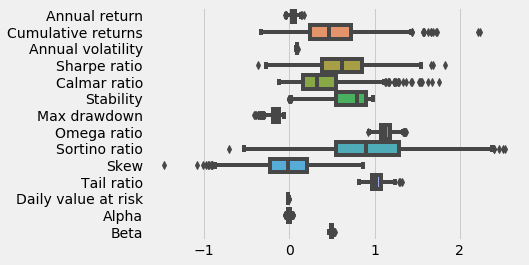

In [17]:
plot_perf_stats(returns=returns, factor_returns=benchmark_rets)

## Returns Analysis

Testing a trading strategy involves backtesting against historical data to fine-tune alpha factor parameters, as well as forward-testing against new market data to validate that the strategy performs well out of sample or if the parameters are too closely tailored to specific historical circumstances.

Pyfolio allows for the designation of an out-of-sample period to simulate walk-forward testing. There are numerous aspects to take into account when testing a strategy to obtain statistically reliable results, which we will address here. 

In [18]:
oos_date = '2017-01-01'

In [19]:
show_perf_stats(returns=returns, 
                factor_returns=benchmark_rets, 
                positions=positions, 
                transactions=transactions, 
                live_start_date=oos_date)

In-sample months: 83
Out-of-sample months: 11


,All,In-sample,Out-of-sample
Annual return,5.0%,4.9%,5.6%
Cumulative returns,47.5%,39.8%,5.5%
Annual volatility,8.6%,9.0%,4.9%
Sharpe ratio,0.61,0.58,1.13
Calmar ratio,0.46,0.45,2.09
Stability,0.93,0.91,0.60
Max drawdown,-10.9%,-10.9%,-2.7%
Omega ratio,1.12,1.12,1.20
Sortino ratio,0.88,0.83,1.70
Skew,-0.03,-0.03,0.07


### Rolling Returns OOS

The `plot_rolling_returns` function displays cumulative in and out-of-sample returns against a user-defined benchmark (we are using the S&P 500):


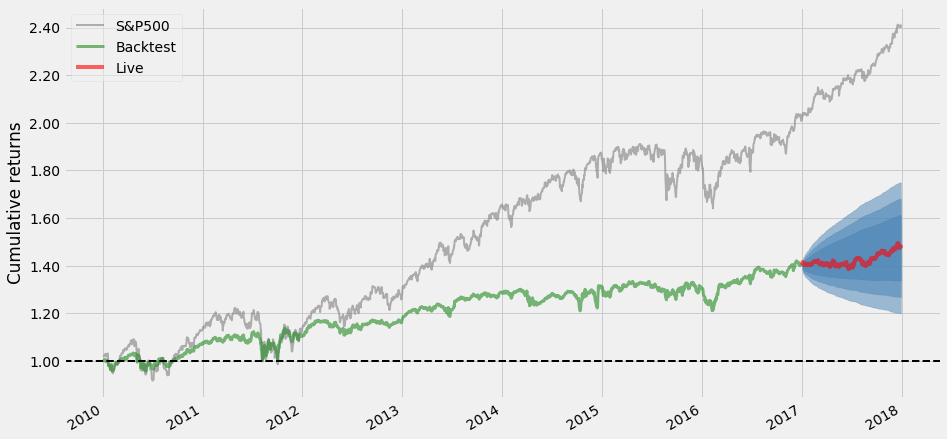

In [20]:
plot_rolling_returns(returns=returns, factor_returns=benchmark_rets, live_start_date=oos_date, cone_std=(1.0, 1.5, 2.0))
plt.gcf().set_size_inches(14, 8)

The plot includes a cone that shows expanding confidence intervals to indicate when out-of-sample returns appear unlikely given random-walk assumptions. Here, our strategy did not perform well against the benchmark during the simulated 2017 out-of-sample period

## Summary Performance Statistics

pyfolio offers several analytic functions and plots. The perf_stats summary displays the annual and cumulative returns, volatility, skew, and kurtosis of returns and the SR. The following additional metrics (which can also be calculated individually) are most important:
- Max drawdown: Highest percentage loss from the previous peak
- Calmar ratio: Annual portfolio return relative to maximal drawdown
- Omega ratio: The probability-weighted ratio of gains versus losses for a return target, zero per default
- Sortino ratio: Excess return relative to downside standard deviation
- Tail ratio: Size of the right tail (gains, the absolute value of the 95th percentile) relative to the size of the left tail (losses, abs. value of the 5th percentile) 
- Daily value at risk (VaR): Loss corresponding to a return two standard deviations below the daily mean
- Alpha: Portfolio return unexplained by the benchmark return
- Beta: Exposure to the benchmark


### Rolling Sharpe

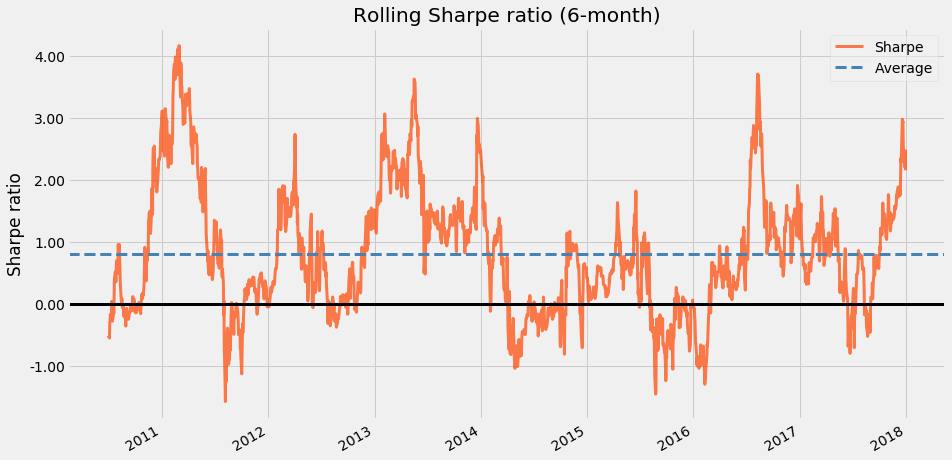

In [21]:
plot_rolling_sharpe(returns=returns)
plt.gcf().set_size_inches(14, 8);

### Rolling Beta

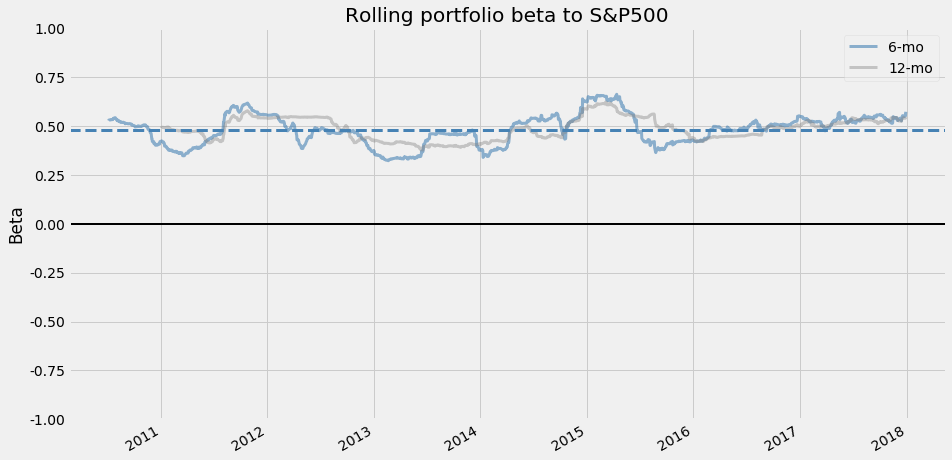

In [22]:
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets)
plt.gcf().set_size_inches(14, 8);

## Drawdown Periods

The plot_drawdown_periods(returns) function plots the principal drawdown periods for the portfolio, and several other plotting functions show the rolling SR and rolling factor exposures to the market beta or the Fama French size, growth, and momentum factors:

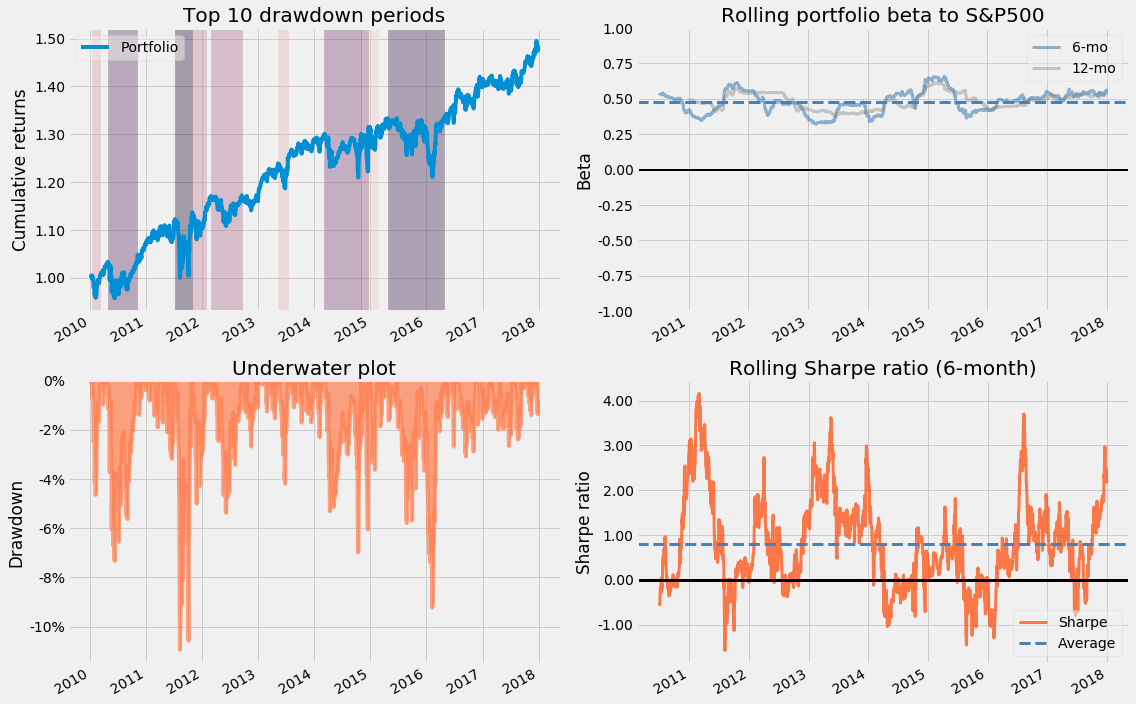

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = ax.flatten()

plot_drawdown_periods(returns=returns, ax=axes[0])
plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[1])
plot_drawdown_underwater(returns=returns, ax=axes[2])
plot_rolling_sharpe(returns=returns)
plt.tight_layout();

This plot, which highlights a subset of the visualization contained in the various tear sheets, illustrates how pyfolio allows us to drill down into the performance characteristics and exposure to fundamental drivers of risk and returns.

## Modeling Event Risk

Pyfolio also includes timelines for various events that you can use to compare the performance of a portfolio to a benchmark during this period, for example, during the fall 2015 selloff following the Brexit vote.

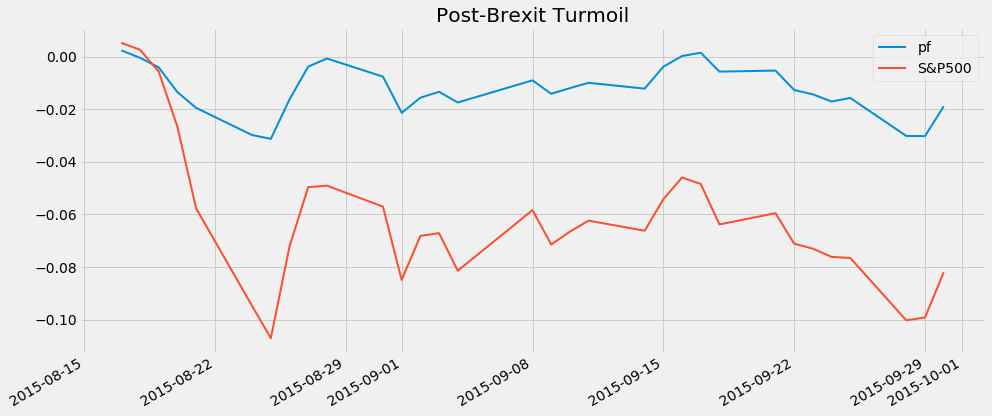

In [24]:
interesting_times = extract_interesting_date_ranges(returns=returns)
(interesting_times['Fall2015']
 .to_frame('pf').join(benchmark_rets)
 .add(1).cumprod().sub(1)
 .plot(lw=2, figsize=(14, 6), title='Post-Brexit Turmoil'))
plt.tight_layout()